In [1]:
# Parameters
n_latent = 20
batch = "chemistry"
dataset = "VALIDATION"
annotation = "Level2"


In [2]:
for v in ['n_latent','batch','dataset','annotation']:
    if v in locals() or v in globals():
        print(f"{v} = {eval(v)}")
    else:
        raise ValeuError(f"{v} is not defined")

n_latent = 20
batch = chemistry
dataset = VALIDATION
annotation = Level2


this notebook is run in *scvi-v112* env (cluster)

In [3]:
import os
import sys

import random 
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc

import scgen

import pynndescent

import pandas as pd

import session_info
import warnings
from pyprojroot.here import here

from sklearn.svm import LinearSVC

from sklearn.metrics import balanced_accuracy_score

import decoupler

import torch

import joblib

sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import get_deltas_v2, batch_removal_v2, aggregating_features, train_patient_classifier, vote_patient_disease

#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

# Setting some parameters
warnings.filterwarnings("ignore")

random_seed = 42

In [4]:
%load_ext autoreload
%autoreload 2

## Loading data
### Loading main adata

In [5]:
adataR = sc.read_h5ad(here('03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse.log1p.h5ad'))

In [6]:
adataR.obs['batch'] = adataR.obs[batch].tolist()
adataR.obs['cell_type'] = adataR.obs[annotation].tolist()

### Loading query adata

In [7]:
adataQ = sc.read_h5ad(here(f"03_downstream_analysis/02_gene_universe_definition/results/05_{dataset}_geneUniverse.log1p.h5ad"))
adataQ

AnnData object with n_obs × n_vars = 849922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'disease', 'sex', 'binned_age'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'
    uns: 'log1p'

In [8]:
adataQ.obs['cell_type'] = adataR.obs[annotation][0] #this is needed just to allow scGen model to transfer anndata setup without errors
adataQ.obs['batch'] = adataQ.obs[batch]
adataQ

AnnData object with n_obs × n_vars = 849922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'disease', 'sex', 'binned_age', 'cell_type', 'batch'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'
    uns: 'log1p'

### Loading scGen model

In [9]:
model_scGen = scgen.SCGEN.load(here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/01_scGen_train_nLat{n_latent}_{batch}_{annotation}"), adata = adataR)

INFO     File                                                                                                      
         /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_Pat
         ientClassifier/scGen/results/01_scGen_train_nLat20_chemistry_Level2/model.pt already downloaded           


## Generating embedding spaces

### Train/reference dataset

In [10]:
adata_scGen = model_scGen.batch_removal()
adata_scGen

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2', 'batch', 'cell_type', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [11]:
pseudobulkTRAIN = aggregating_features(Z=adata_scGen.obsm['corrected_latent'], 
                     min_observation=0, 
                     obsDF=adata_scGen.obs[['sampleID','disease','Level1','batch','studyID']], obs_names_col = ['sampleID','Level1'])

In [12]:
outputFilePath = here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/02_MAIN_scGenIntegrated_PSEUDOBULK_{n_latent}nLT_{batch}_{annotation}")
if os.path.isfile(outputFilePath):
    print("File already saved")
else:
    pseudobulkTRAIN.write(outputFilePath, compression = 'gzip')

File already saved


### Query dataset

**Extracting the NOT batch-corrected embedding**

In [13]:
UncorrectedEmbR =  model_scGen.get_latent_representation()
UncorrectedEmbR.shape

(4435922, 20)

**Using py NN descent to transfer cell-type labels**

In [14]:
ref_nn_index = pynndescent.NNDescent(UncorrectedEmbR, random_state = random_seed)
ref_nn_index.prepare()

In [15]:
UncorrectedEmbQ = model_scGen.get_latent_representation(adataQ)
UncorrectedEmbQ.shape

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(849922, 20)

In [16]:
ref_neighbors, ref_distances = ref_nn_index.query(UncorrectedEmbQ)

In [17]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2 # gaussian distribution
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

In [18]:
import numba
@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

In [19]:
# for each annotation level, get prediction and uncertainty
label_keys = ['Level1','Level2','disease']
for l in label_keys:
    ref_cats = model_scGen.adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(model_scGen.adata.obs[l].cat.categories)[p]
    adataQ.obs[l + "_pred"], adataQ.obs[l + "_uncertainty"] = p, u

We also compute the accuracy of trasnfering the disease label to each cells

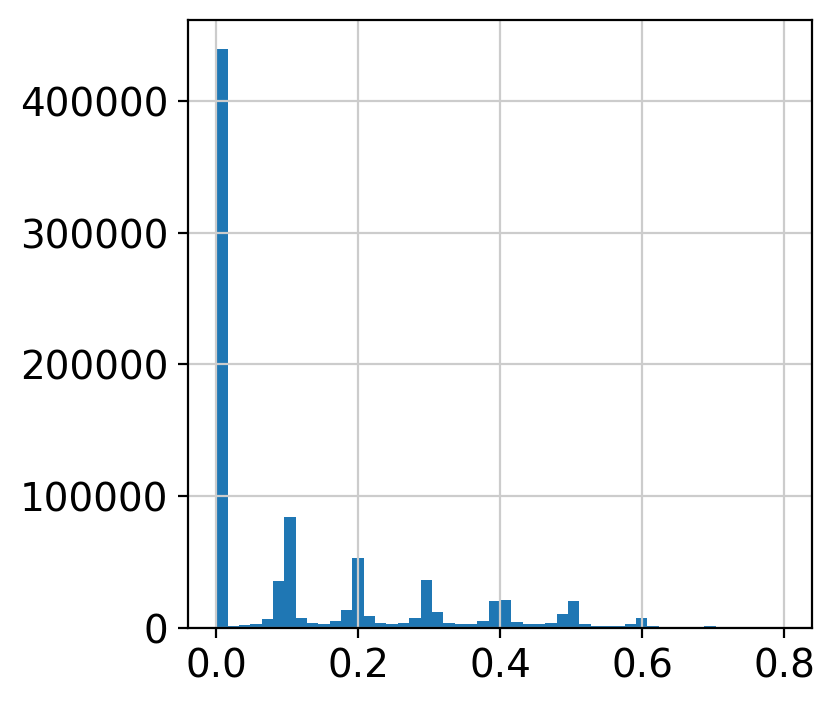

In [20]:
adataQ.obs.Level1_uncertainty.hist(bins=50)
plt.show()

In [21]:
BASlist = []

thrValues = np.arange(np.min(adataQ.obs[f"{annotation}_uncertainty"]), np.max(adataQ.obs[f"{annotation}_uncertainty"]), 0.05)

for cell_uncThr in thrValues:
  
    diseaseBAS = balanced_accuracy_score(y_pred=adataQ.obs.query(f"{annotation}_uncertainty < @cell_uncThr")['disease_pred'], 
                                         y_true=adataQ.obs.query(f"{annotation}_uncertainty < @cell_uncThr")['disease'])
    BASlist.append(diseaseBAS)
    #print(f"Balance accuracy score for disease prediction at single-cell level = {diseaseBAS}, when uncertanty lower than {disease_uncThr}")

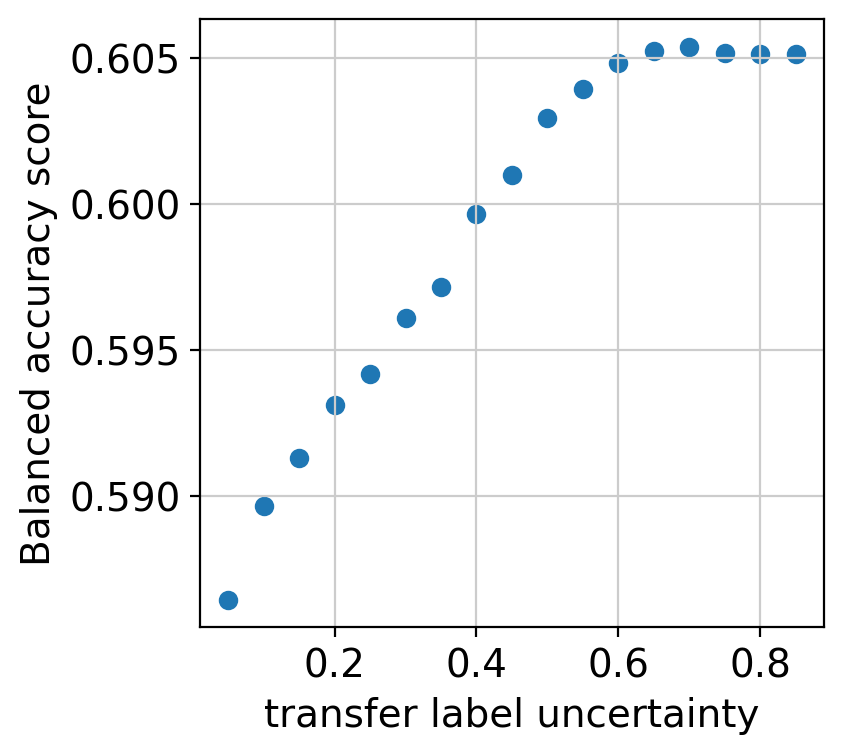

In [22]:
plt.scatter(thrValues, BASlist)
plt.xlabel('transfer label uncertainty')
plt.ylabel('Balanced accuracy score')
plt.show()

**Learning the batch correction deltas**

In [23]:
deltas = get_deltas_v2(model_scGen, batchLevels=['cell_type','batch'])

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 1/256 [00:03<13:40,  3.22s/it]

  1%|          | 2/256 [00:04<08:36,  2.03s/it]

  1%|          | 3/256 [00:05<07:12,  1.71s/it]

  2%|▏         | 4/256 [00:07<06:53,  1.64s/it]

  2%|▏         | 5/256 [00:08<06:27,  1.55s/it]

  2%|▏         | 6/256 [00:10<06:13,  1.50s/it]

  3%|▎         | 7/256 [00:11<05:55,  1.43s/it]

  3%|▎         | 8/256 [00:12<05:51,  1.42s/it]

  4%|▎         | 9/256 [00:14<05:42,  1.39s/it]

  4%|▍         | 10/256 [00:15<05:47,  1.41s/it]

  4%|▍         | 11/256 [00:16<05:38,  1.38s/it]

  5%|▍         | 12/256 [00:18<05:41,  1.40s/it]

  5%|▌         | 13/256 [00:19<05:31,  1.36s/it]

  5%|▌         | 14/256 [00:20<05:20,  1.33s/it]

  6%|▌         | 15/256 [00:22<05:17,  1.32s/it]

  6%|▋         | 16/256 [00:23<05:25,  1.36s/it]

  7%|▋         | 17/256 [00:24<05:30,  1.38s/it]

  7%|▋         | 18/256 [00:26<05:31,  1.39s/it]

  7%|▋         | 19/256 [00:27<05:25,  1.37s/it]

  8%|▊         | 20/256 [00:29<05:20,  1.36s/it]

  8%|▊         | 21/256 [00:30<05:01,  1.28s/it]

  9%|▊         | 22/256 [00:31<04:41,  1.20s/it]

  9%|▉         | 23/256 [00:32<04:28,  1.15s/it]

  9%|▉         | 24/256 [00:33<04:30,  1.16s/it]

 10%|▉         | 25/256 [00:34<04:33,  1.19s/it]

 10%|█         | 26/256 [00:35<04:32,  1.19s/it]

 11%|█         | 27/256 [00:36<04:28,  1.17s/it]

 11%|█         | 28/256 [00:38<04:37,  1.22s/it]

 11%|█▏        | 29/256 [00:39<04:38,  1.22s/it]

 12%|█▏        | 30/256 [00:40<04:33,  1.21s/it]

 12%|█▏        | 31/256 [00:41<04:34,  1.22s/it]

 12%|█▎        | 32/256 [00:43<04:36,  1.24s/it]

 13%|█▎        | 33/256 [00:44<04:19,  1.16s/it]

 13%|█▎        | 34/256 [00:45<04:06,  1.11s/it]

 14%|█▎        | 35/256 [00:46<03:59,  1.09s/it]

 14%|█▍        | 36/256 [00:47<03:54,  1.07s/it]

 14%|█▍        | 37/256 [00:48<03:52,  1.06s/it]

 15%|█▍        | 38/256 [00:49<03:43,  1.03s/it]

 15%|█▌        | 39/256 [00:50<03:42,  1.03s/it]

 16%|█▌        | 40/256 [00:51<03:44,  1.04s/it]

 16%|█▌        | 41/256 [00:52<03:58,  1.11s/it]

 16%|█▋        | 42/256 [00:54<04:25,  1.24s/it]

 17%|█▋        | 43/256 [00:55<04:28,  1.26s/it]

 17%|█▋        | 44/256 [00:56<04:32,  1.28s/it]

 18%|█▊        | 45/256 [00:57<04:07,  1.17s/it]

 18%|█▊        | 46/256 [00:58<03:53,  1.11s/it]

 18%|█▊        | 47/256 [00:59<03:37,  1.04s/it]

 19%|█▉        | 48/256 [01:00<03:33,  1.03s/it]

 19%|█▉        | 49/256 [01:01<03:22,  1.02it/s]

 20%|█▉        | 50/256 [01:02<03:15,  1.05it/s]

 20%|█▉        | 51/256 [01:03<03:12,  1.06it/s]

 20%|██        | 52/256 [01:04<03:14,  1.05it/s]

 21%|██        | 53/256 [01:05<03:18,  1.02it/s]

 21%|██        | 54/256 [01:06<03:20,  1.01it/s]

 21%|██▏       | 55/256 [01:07<03:14,  1.03it/s]

 22%|██▏       | 56/256 [01:08<03:12,  1.04it/s]

 22%|██▏       | 57/256 [01:09<03:11,  1.04it/s]

 23%|██▎       | 58/256 [01:10<03:16,  1.01it/s]

 23%|██▎       | 59/256 [01:11<03:12,  1.02it/s]

 23%|██▎       | 60/256 [01:12<03:16,  1.00s/it]

 24%|██▍       | 61/256 [01:13<03:23,  1.04s/it]

 24%|██▍       | 62/256 [01:14<03:22,  1.04s/it]

 25%|██▍       | 63/256 [01:15<03:21,  1.04s/it]

 25%|██▌       | 64/256 [01:16<03:23,  1.06s/it]

 25%|██▌       | 65/256 [01:17<03:14,  1.02s/it]

 26%|██▌       | 66/256 [01:18<03:07,  1.01it/s]

 26%|██▌       | 67/256 [01:19<03:06,  1.01it/s]

 27%|██▋       | 68/256 [01:20<03:01,  1.04it/s]

 27%|██▋       | 69/256 [01:21<03:37,  1.16s/it]

 27%|██▋       | 70/256 [01:23<03:48,  1.23s/it]

 28%|██▊       | 71/256 [01:24<04:07,  1.34s/it]

 28%|██▊       | 72/256 [01:26<04:23,  1.43s/it]

 29%|██▊       | 73/256 [01:28<05:05,  1.67s/it]

 29%|██▉       | 74/256 [01:30<05:24,  1.79s/it]

 29%|██▉       | 75/256 [01:33<06:07,  2.03s/it]

 30%|██▉       | 76/256 [01:35<06:32,  2.18s/it]

 30%|███       | 77/256 [01:37<05:41,  1.91s/it]

 30%|███       | 78/256 [01:38<05:12,  1.75s/it]

 31%|███       | 79/256 [01:40<04:58,  1.69s/it]

 31%|███▏      | 80/256 [01:41<04:44,  1.61s/it]

 32%|███▏      | 81/256 [01:43<04:37,  1.59s/it]

 32%|███▏      | 82/256 [01:44<04:31,  1.56s/it]

 32%|███▏      | 83/256 [01:46<04:26,  1.54s/it]

 33%|███▎      | 84/256 [01:47<04:26,  1.55s/it]

 33%|███▎      | 85/256 [01:49<04:37,  1.62s/it]

 34%|███▎      | 86/256 [01:51<05:22,  1.90s/it]

 34%|███▍      | 87/256 [01:54<05:30,  1.95s/it]

 34%|███▍      | 88/256 [01:55<05:25,  1.94s/it]

 35%|███▍      | 89/256 [01:57<04:52,  1.75s/it]

 35%|███▌      | 90/256 [01:58<04:27,  1.61s/it]

 36%|███▌      | 91/256 [01:59<04:09,  1.51s/it]

 36%|███▌      | 92/256 [02:01<04:11,  1.53s/it]

 36%|███▋      | 93/256 [02:03<04:37,  1.70s/it]

 37%|███▋      | 94/256 [02:05<04:39,  1.72s/it]

 37%|███▋      | 95/256 [02:07<04:42,  1.75s/it]

 38%|███▊      | 96/256 [02:09<04:48,  1.81s/it]

 38%|███▊      | 97/256 [02:10<04:26,  1.68s/it]

 38%|███▊      | 98/256 [02:11<04:09,  1.58s/it]

 39%|███▊      | 99/256 [02:12<03:49,  1.46s/it]

 39%|███▉      | 100/256 [02:14<03:48,  1.46s/it]

 39%|███▉      | 101/256 [02:15<03:35,  1.39s/it]

 40%|███▉      | 102/256 [02:16<03:30,  1.37s/it]

 40%|████      | 103/256 [02:18<03:21,  1.31s/it]

 41%|████      | 104/256 [02:19<03:23,  1.34s/it]

 41%|████      | 105/256 [02:20<03:14,  1.29s/it]

 41%|████▏     | 106/256 [02:21<03:05,  1.24s/it]

 42%|████▏     | 107/256 [02:23<03:05,  1.24s/it]

 42%|████▏     | 108/256 [02:24<03:01,  1.23s/it]

 43%|████▎     | 109/256 [02:25<02:51,  1.17s/it]

 43%|████▎     | 110/256 [02:26<02:44,  1.13s/it]

 43%|████▎     | 111/256 [02:27<02:43,  1.13s/it]

 44%|████▍     | 112/256 [02:28<02:41,  1.12s/it]

 44%|████▍     | 113/256 [02:29<02:51,  1.20s/it]

 45%|████▍     | 114/256 [02:31<03:02,  1.29s/it]

 45%|████▍     | 115/256 [02:32<03:03,  1.30s/it]

 45%|████▌     | 116/256 [02:34<03:07,  1.34s/it]

 46%|████▌     | 117/256 [02:35<02:48,  1.21s/it]

 46%|████▌     | 118/256 [02:36<02:41,  1.17s/it]

 46%|████▋     | 119/256 [02:37<02:29,  1.09s/it]

 47%|████▋     | 120/256 [02:38<02:22,  1.05s/it]

 47%|████▋     | 121/256 [02:38<02:17,  1.02s/it]

 48%|████▊     | 122/256 [02:40<02:20,  1.05s/it]

 48%|████▊     | 123/256 [02:41<02:19,  1.05s/it]

 48%|████▊     | 124/256 [02:42<02:17,  1.04s/it]

 49%|████▉     | 125/256 [02:43<02:10,  1.00it/s]

 49%|████▉     | 126/256 [02:43<02:06,  1.03it/s]

 50%|████▉     | 127/256 [02:44<02:04,  1.04it/s]

 50%|█████     | 128/256 [02:45<02:01,  1.06it/s]

 50%|█████     | 129/256 [02:46<01:59,  1.06it/s]

 51%|█████     | 130/256 [02:47<02:00,  1.05it/s]

 51%|█████     | 131/256 [02:48<01:57,  1.06it/s]

 52%|█████▏    | 132/256 [02:49<01:57,  1.05it/s]

 52%|█████▏    | 133/256 [02:51<02:32,  1.24s/it]

 52%|█████▏    | 134/256 [02:53<02:55,  1.44s/it]

 53%|█████▎    | 135/256 [02:55<03:00,  1.49s/it]

 53%|█████▎    | 136/256 [02:57<03:16,  1.64s/it]

 54%|█████▎    | 137/256 [02:57<02:50,  1.43s/it]

 54%|█████▍    | 138/256 [02:58<02:29,  1.27s/it]

 54%|█████▍    | 139/256 [02:59<02:16,  1.16s/it]

 55%|█████▍    | 140/256 [03:00<02:06,  1.09s/it]

 55%|█████▌    | 141/256 [03:02<02:12,  1.15s/it]

 55%|█████▌    | 142/256 [03:03<02:11,  1.15s/it]

 56%|█████▌    | 143/256 [03:04<02:06,  1.12s/it]

 56%|█████▋    | 144/256 [03:05<02:14,  1.20s/it]

 57%|█████▋    | 145/256 [03:06<02:09,  1.16s/it]

 57%|█████▋    | 146/256 [03:07<02:06,  1.15s/it]

 57%|█████▋    | 147/256 [03:09<02:10,  1.19s/it]

 58%|█████▊    | 148/256 [03:10<02:06,  1.18s/it]

 58%|█████▊    | 149/256 [03:11<02:16,  1.27s/it]

 59%|█████▊    | 150/256 [03:13<02:24,  1.36s/it]

 59%|█████▉    | 151/256 [03:14<02:25,  1.39s/it]

 59%|█████▉    | 152/256 [03:16<02:29,  1.44s/it]

 60%|█████▉    | 153/256 [03:17<02:18,  1.34s/it]

 60%|██████    | 154/256 [03:18<02:06,  1.24s/it]

 61%|██████    | 155/256 [03:19<01:59,  1.18s/it]

 61%|██████    | 156/256 [03:20<01:53,  1.13s/it]

 61%|██████▏   | 157/256 [03:23<02:40,  1.62s/it]

 62%|██████▏   | 158/256 [03:25<03:11,  1.96s/it]

 62%|██████▏   | 159/256 [03:28<03:31,  2.18s/it]

 62%|██████▎   | 160/256 [03:31<03:53,  2.43s/it]

 63%|██████▎   | 161/256 [03:32<03:15,  2.06s/it]

 63%|██████▎   | 162/256 [03:34<02:50,  1.81s/it]

 64%|██████▎   | 163/256 [03:35<02:33,  1.65s/it]

 64%|██████▍   | 164/256 [03:36<02:23,  1.56s/it]

 64%|██████▍   | 165/256 [03:38<02:14,  1.48s/it]

 65%|██████▍   | 166/256 [03:39<02:07,  1.42s/it]

 65%|██████▌   | 167/256 [03:40<02:00,  1.36s/it]

 66%|██████▌   | 168/256 [03:41<01:59,  1.36s/it]

 66%|██████▌   | 169/256 [03:42<01:51,  1.28s/it]

 66%|██████▋   | 170/256 [03:44<01:44,  1.22s/it]

 67%|██████▋   | 171/256 [03:45<01:41,  1.20s/it]

 67%|██████▋   | 172/256 [03:46<01:39,  1.18s/it]

 68%|██████▊   | 173/256 [03:47<01:37,  1.18s/it]

 68%|██████▊   | 174/256 [03:48<01:37,  1.18s/it]

 68%|██████▊   | 175/256 [03:49<01:35,  1.18s/it]

 69%|██████▉   | 176/256 [03:51<01:35,  1.19s/it]

 69%|██████▉   | 177/256 [03:52<01:33,  1.19s/it]

 70%|██████▉   | 178/256 [03:53<01:36,  1.24s/it]

 70%|██████▉   | 179/256 [03:54<01:37,  1.27s/it]

 70%|███████   | 180/256 [03:56<01:38,  1.30s/it]

 71%|███████   | 181/256 [03:57<01:35,  1.27s/it]

 71%|███████   | 182/256 [03:58<01:35,  1.29s/it]

 71%|███████▏  | 183/256 [04:00<01:31,  1.25s/it]

 72%|███████▏  | 184/256 [04:01<01:28,  1.22s/it]

 72%|███████▏  | 185/256 [04:02<01:21,  1.15s/it]

 73%|███████▎  | 186/256 [04:03<01:20,  1.15s/it]

 73%|███████▎  | 187/256 [04:04<01:19,  1.15s/it]

 73%|███████▎  | 188/256 [04:05<01:20,  1.19s/it]

 74%|███████▍  | 189/256 [04:07<01:27,  1.30s/it]

 74%|███████▍  | 190/256 [04:08<01:30,  1.38s/it]

 75%|███████▍  | 191/256 [04:10<01:29,  1.38s/it]

 75%|███████▌  | 192/256 [04:11<01:33,  1.47s/it]

 75%|███████▌  | 193/256 [04:12<01:23,  1.33s/it]

 76%|███████▌  | 194/256 [04:13<01:17,  1.24s/it]

 76%|███████▌  | 195/256 [04:15<01:16,  1.25s/it]

 77%|███████▋  | 196/256 [04:16<01:10,  1.17s/it]

 77%|███████▋  | 197/256 [04:17<01:05,  1.10s/it]

 77%|███████▋  | 198/256 [04:18<01:00,  1.04s/it]

 78%|███████▊  | 199/256 [04:19<00:58,  1.02s/it]

 78%|███████▊  | 200/256 [04:20<00:56,  1.01s/it]

 79%|███████▊  | 201/256 [04:21<00:57,  1.04s/it]

 79%|███████▉  | 202/256 [04:22<00:57,  1.06s/it]

 79%|███████▉  | 203/256 [04:23<00:56,  1.07s/it]

 80%|███████▉  | 204/256 [04:24<00:56,  1.09s/it]

 80%|████████  | 205/256 [04:25<00:52,  1.03s/it]

 80%|████████  | 206/256 [04:26<00:49,  1.01it/s]

 81%|████████  | 207/256 [04:27<00:46,  1.06it/s]

 81%|████████▏ | 208/256 [04:27<00:43,  1.09it/s]

 82%|████████▏ | 209/256 [04:29<00:47,  1.00s/it]

 82%|████████▏ | 210/256 [04:30<00:50,  1.10s/it]

 82%|████████▏ | 211/256 [04:31<00:53,  1.18s/it]

 83%|████████▎ | 212/256 [04:33<00:51,  1.18s/it]

 83%|████████▎ | 213/256 [04:34<00:52,  1.22s/it]

 84%|████████▎ | 214/256 [04:35<00:53,  1.28s/it]

 84%|████████▍ | 215/256 [04:36<00:51,  1.26s/it]

 84%|████████▍ | 216/256 [04:38<00:51,  1.28s/it]

 85%|████████▍ | 217/256 [04:39<00:49,  1.28s/it]

 85%|████████▌ | 218/256 [04:40<00:49,  1.29s/it]

 86%|████████▌ | 219/256 [04:42<00:49,  1.33s/it]

 86%|████████▌ | 220/256 [04:43<00:46,  1.29s/it]

 86%|████████▋ | 221/256 [04:44<00:41,  1.19s/it]

 87%|████████▋ | 222/256 [04:45<00:38,  1.15s/it]

 87%|████████▋ | 223/256 [04:46<00:36,  1.10s/it]

 88%|████████▊ | 224/256 [04:47<00:33,  1.04s/it]

 88%|████████▊ | 225/256 [04:48<00:33,  1.07s/it]

 88%|████████▊ | 226/256 [04:49<00:34,  1.15s/it]

 89%|████████▊ | 227/256 [04:51<00:33,  1.17s/it]

 89%|████████▉ | 228/256 [04:52<00:33,  1.21s/it]

 89%|████████▉ | 229/256 [04:53<00:34,  1.28s/it]

 90%|████████▉ | 230/256 [04:55<00:35,  1.35s/it]

 90%|█████████ | 231/256 [04:56<00:34,  1.37s/it]

 91%|█████████ | 232/256 [04:58<00:36,  1.51s/it]

 91%|█████████ | 233/256 [04:59<00:30,  1.33s/it]

 91%|█████████▏| 234/256 [05:00<00:26,  1.20s/it]

 92%|█████████▏| 235/256 [05:01<00:24,  1.15s/it]

 92%|█████████▏| 236/256 [05:02<00:21,  1.08s/it]

 93%|█████████▎| 237/256 [05:03<00:20,  1.06s/it]

 93%|█████████▎| 238/256 [05:04<00:18,  1.03s/it]

 93%|█████████▎| 239/256 [05:05<00:17,  1.01s/it]

 94%|█████████▍| 240/256 [05:06<00:16,  1.02s/it]

 94%|█████████▍| 241/256 [05:07<00:15,  1.06s/it]

 95%|█████████▍| 242/256 [05:08<00:15,  1.08s/it]

 95%|█████████▍| 243/256 [05:09<00:14,  1.13s/it]

 95%|█████████▌| 244/256 [05:11<00:14,  1.18s/it]

 96%|█████████▌| 245/256 [05:12<00:13,  1.20s/it]

 96%|█████████▌| 246/256 [05:13<00:11,  1.20s/it]

 96%|█████████▋| 247/256 [05:14<00:10,  1.15s/it]

 97%|█████████▋| 248/256 [05:15<00:09,  1.16s/it]

 97%|█████████▋| 249/256 [05:17<00:08,  1.20s/it]

 98%|█████████▊| 250/256 [05:18<00:07,  1.20s/it]

 98%|█████████▊| 251/256 [05:19<00:06,  1.21s/it]

 98%|█████████▊| 252/256 [05:20<00:04,  1.24s/it]

 99%|█████████▉| 253/256 [05:21<00:03,  1.16s/it]

 99%|█████████▉| 254/256 [05:23<00:02,  1.16s/it]

100%|█████████▉| 255/256 [05:23<00:01,  1.10s/it]

100%|██████████| 256/256 [05:24<00:00,  1.07s/it]

100%|██████████| 256/256 [05:24<00:00,  1.27s/it]

**Apply the learned deltas on the query data**

In [24]:
adataQ.obs['cell_type'] = adataQ.obs[f'{annotation}_pred']
adataQcorr = batch_removal_v2(model_scGen, adata=adataQ, deltas=deltas, batchLevels=['cell_type','batch'])

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:00<00:45,  5.49it/s]

  1%|          | 3/252 [00:00<00:28,  8.88it/s]

  2%|▏         | 5/252 [00:00<00:25,  9.81it/s]

  3%|▎         | 7/252 [00:00<00:24, 10.03it/s]

  4%|▎         | 9/252 [00:00<00:24,  9.79it/s]

  4%|▍         | 10/252 [00:01<00:26,  9.23it/s]

  4%|▍         | 11/252 [00:01<00:26,  9.26it/s]

  5%|▌         | 13/252 [00:01<00:23, 10.16it/s]

  6%|▌         | 15/252 [00:01<00:23, 10.29it/s]

  7%|▋         | 17/252 [00:01<00:23,  9.90it/s]

  8%|▊         | 19/252 [00:01<00:23,  9.90it/s]

  8%|▊         | 20/252 [00:02<00:23,  9.81it/s]

  8%|▊         | 21/252 [00:02<00:23,  9.73it/s]

  9%|▉         | 23/252 [00:02<00:23,  9.59it/s]

 10%|▉         | 25/252 [00:02<00:21, 10.70it/s]

 11%|█         | 27/252 [00:02<00:21, 10.64it/s]

 12%|█▏        | 29/252 [00:02<00:22,  9.99it/s]

 12%|█▏        | 31/252 [00:03<00:21, 10.12it/s]

 13%|█▎        | 33/252 [00:03<00:20, 10.55it/s]

 14%|█▍        | 35/252 [00:03<00:21, 10.23it/s]

 15%|█▍        | 37/252 [00:03<00:20, 10.27it/s]

 15%|█▌        | 39/252 [00:03<00:20, 10.49it/s]

 16%|█▋        | 41/252 [00:04<00:19, 10.94it/s]

 17%|█▋        | 43/252 [00:04<00:19, 10.76it/s]

 18%|█▊        | 45/252 [00:04<00:18, 11.16it/s]

 19%|█▊        | 47/252 [00:04<00:17, 11.41it/s]

 19%|█▉        | 49/252 [00:04<00:18, 11.20it/s]

 20%|██        | 51/252 [00:04<00:18, 11.04it/s]

 21%|██        | 53/252 [00:05<00:17, 11.60it/s]

 22%|██▏       | 55/252 [00:05<00:17, 11.27it/s]

 23%|██▎       | 57/252 [00:05<00:17, 11.17it/s]

 23%|██▎       | 59/252 [00:05<00:18, 10.48it/s]

 24%|██▍       | 61/252 [00:05<00:18, 10.08it/s]

 25%|██▌       | 63/252 [00:06<00:17, 10.79it/s]

 26%|██▌       | 65/252 [00:06<00:16, 11.07it/s]

 27%|██▋       | 67/252 [00:06<00:17, 10.41it/s]

 27%|██▋       | 69/252 [00:06<00:18,  9.92it/s]

 28%|██▊       | 71/252 [00:06<00:19,  9.14it/s]

 29%|██▊       | 72/252 [00:07<00:20,  8.68it/s]

 29%|██▉       | 73/252 [00:07<00:22,  8.10it/s]

 29%|██▉       | 74/252 [00:07<00:23,  7.49it/s]

 30%|██▉       | 75/252 [00:07<00:22,  7.95it/s]

 31%|███       | 77/252 [00:07<00:19,  8.87it/s]

 31%|███       | 78/252 [00:07<00:19,  8.74it/s]

 31%|███▏      | 79/252 [00:07<00:19,  8.73it/s]

 32%|███▏      | 81/252 [00:08<00:18,  9.04it/s]

 33%|███▎      | 82/252 [00:08<00:19,  8.56it/s]

 33%|███▎      | 84/252 [00:08<00:19,  8.75it/s]

 34%|███▎      | 85/252 [00:08<00:18,  8.83it/s]

 35%|███▍      | 87/252 [00:08<00:17,  9.55it/s]

 35%|███▌      | 89/252 [00:08<00:15, 10.20it/s]

 36%|███▌      | 91/252 [00:09<00:17,  9.20it/s]

 37%|███▋      | 93/252 [00:09<00:16,  9.48it/s]

 37%|███▋      | 94/252 [00:09<00:18,  8.63it/s]

 38%|███▊      | 96/252 [00:09<00:17,  9.15it/s]

 39%|███▉      | 98/252 [00:09<00:16,  9.44it/s]

 40%|███▉      | 100/252 [00:10<00:15,  9.79it/s]

 40%|████      | 102/252 [00:10<00:14, 10.18it/s]

 41%|████▏     | 104/252 [00:10<00:14, 10.37it/s]

 42%|████▏     | 106/252 [00:10<00:13, 10.46it/s]

 43%|████▎     | 108/252 [00:10<00:13, 10.31it/s]

 44%|████▎     | 110/252 [00:11<00:13, 10.30it/s]

 44%|████▍     | 112/252 [00:11<00:14,  9.72it/s]

 45%|████▌     | 114/252 [00:11<00:14,  9.48it/s]

 46%|████▌     | 116/252 [00:11<00:14,  9.55it/s]

 47%|████▋     | 118/252 [00:11<00:13, 10.24it/s]

 48%|████▊     | 120/252 [00:12<00:12, 10.32it/s]

 48%|████▊     | 122/252 [00:12<00:12, 10.55it/s]

 49%|████▉     | 124/252 [00:12<00:12, 10.63it/s]

 50%|█████     | 126/252 [00:12<00:11, 10.80it/s]

 51%|█████     | 128/252 [00:12<00:11, 11.03it/s]

 52%|█████▏    | 130/252 [00:13<00:11, 10.94it/s]

 52%|█████▏    | 132/252 [00:13<00:10, 11.02it/s]

 53%|█████▎    | 134/252 [00:13<00:11,  9.91it/s]

 54%|█████▍    | 136/252 [00:13<00:11, 10.22it/s]

 55%|█████▍    | 138/252 [00:13<00:11, 10.27it/s]

 56%|█████▌    | 140/252 [00:14<00:11,  9.96it/s]

 56%|█████▋    | 142/252 [00:14<00:11,  9.36it/s]

 57%|█████▋    | 143/252 [00:14<00:11,  9.43it/s]

 58%|█████▊    | 145/252 [00:14<00:11,  9.51it/s]

 58%|█████▊    | 146/252 [00:14<00:11,  9.25it/s]

 58%|█████▊    | 147/252 [00:14<00:11,  8.96it/s]

 59%|█████▊    | 148/252 [00:14<00:12,  8.31it/s]

 59%|█████▉    | 149/252 [00:15<00:12,  8.17it/s]

 60%|█████▉    | 150/252 [00:15<00:12,  8.26it/s]

 60%|██████    | 152/252 [00:15<00:10,  9.25it/s]

 61%|██████    | 153/252 [00:15<00:10,  9.26it/s]

 61%|██████    | 154/252 [00:15<00:12,  7.76it/s]

 62%|██████▏   | 155/252 [00:15<00:14,  6.75it/s]

 62%|██████▏   | 156/252 [00:16<00:14,  6.45it/s]

 62%|██████▏   | 157/252 [00:16<00:16,  5.80it/s]

 63%|██████▎   | 158/252 [00:16<00:14,  6.58it/s]

 63%|██████▎   | 160/252 [00:16<00:11,  7.90it/s]

 64%|██████▍   | 162/252 [00:16<00:10,  8.50it/s]

 65%|██████▍   | 163/252 [00:16<00:10,  8.52it/s]

 65%|██████▌   | 164/252 [00:17<00:10,  8.57it/s]

 65%|██████▌   | 165/252 [00:17<00:10,  7.99it/s]

 66%|██████▋   | 167/252 [00:17<00:09,  8.81it/s]

 67%|██████▋   | 168/252 [00:17<00:09,  8.57it/s]

 67%|██████▋   | 169/252 [00:17<00:09,  8.72it/s]

 68%|██████▊   | 171/252 [00:17<00:09,  8.85it/s]

 69%|██████▊   | 173/252 [00:18<00:08,  9.29it/s]

 69%|██████▉   | 175/252 [00:18<00:08,  9.50it/s]

 70%|██████▉   | 176/252 [00:18<00:08,  9.12it/s]

 70%|███████   | 177/252 [00:18<00:08,  8.64it/s]

 71%|███████   | 179/252 [00:18<00:08,  9.07it/s]

 72%|███████▏  | 181/252 [00:18<00:07,  9.77it/s]

 72%|███████▏  | 182/252 [00:18<00:07,  9.69it/s]

 73%|███████▎  | 184/252 [00:19<00:06, 10.37it/s]

 74%|███████▍  | 186/252 [00:19<00:06,  9.78it/s]

 74%|███████▍  | 187/252 [00:19<00:06,  9.70it/s]

 75%|███████▌  | 189/252 [00:19<00:06,  9.79it/s]

 76%|███████▌  | 191/252 [00:19<00:06, 10.12it/s]

 77%|███████▋  | 193/252 [00:20<00:05, 10.07it/s]

 77%|███████▋  | 195/252 [00:20<00:05, 10.19it/s]

 78%|███████▊  | 197/252 [00:20<00:05, 10.84it/s]

 79%|███████▉  | 199/252 [00:20<00:05, 10.56it/s]

 80%|███████▉  | 201/252 [00:20<00:04, 10.41it/s]

 81%|████████  | 203/252 [00:21<00:04, 10.75it/s]

 81%|████████▏ | 205/252 [00:21<00:04, 10.81it/s]

 82%|████████▏ | 207/252 [00:21<00:04,  9.95it/s]

 83%|████████▎ | 209/252 [00:21<00:04, 10.13it/s]

 84%|████████▎ | 211/252 [00:21<00:03, 10.25it/s]

 85%|████████▍ | 213/252 [00:22<00:03,  9.76it/s]

 85%|████████▌ | 215/252 [00:22<00:03,  9.62it/s]

 86%|████████▌ | 216/252 [00:22<00:03,  9.60it/s]

 87%|████████▋ | 218/252 [00:22<00:03, 10.31it/s]

 87%|████████▋ | 220/252 [00:22<00:03, 10.41it/s]

 88%|████████▊ | 222/252 [00:22<00:02, 10.58it/s]

 89%|████████▉ | 224/252 [00:23<00:02, 10.61it/s]

 90%|████████▉ | 226/252 [00:23<00:02, 10.48it/s]

 90%|█████████ | 228/252 [00:23<00:02, 10.24it/s]

 91%|█████████▏| 230/252 [00:23<00:02, 10.52it/s]

 92%|█████████▏| 232/252 [00:23<00:01, 10.61it/s]

 93%|█████████▎| 234/252 [00:24<00:01, 10.53it/s]

 94%|█████████▎| 236/252 [00:24<00:01, 10.41it/s]

 94%|█████████▍| 238/252 [00:24<00:01, 10.82it/s]

 95%|█████████▌| 240/252 [00:24<00:01, 11.15it/s]

 96%|█████████▌| 242/252 [00:24<00:00, 11.49it/s]

 97%|█████████▋| 244/252 [00:24<00:00, 12.10it/s]

 98%|█████████▊| 246/252 [00:25<00:00, 11.70it/s]

 98%|█████████▊| 248/252 [00:25<00:00, 10.63it/s]

 99%|█████████▉| 250/252 [00:25<00:00, 10.25it/s]

100%|██████████| 252/252 [00:25<00:00, 10.52it/s]

100%|██████████| 252/252 [00:25<00:00,  9.82it/s]

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [25]:
pseudobulkQUERY = aggregating_features(Z=adataQcorr.obsm['corrected_latent'], 
                     min_observation=0, 
                     obsDF=adataQcorr.obs[['sampleID','disease','Level1_pred','batch','studyID']], obs_names_col = ['sampleID','Level1_pred'])

In [26]:
pseudobulkQUERY.write(here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/02_{dataset}_scGenIntegrated_PSEUDOBULK_{n_latent}nLT_{batch}_{annotation}"), compression = 'gzip')

## Test one classifier

**Remove unwanted cell-types**

In [27]:
pseudobulkTRAINfilt = pseudobulkTRAIN[~pseudobulkTRAIN.obs.Level1.isin(['Cycling_cells','RBC','Progenitors','Platelets'])]
pseudobulkQUERYfilt = pseudobulkQUERY[~pseudobulkQUERY.obs.Level1_pred.isin(['Cycling_cells','RBC','Progenitors','Platelets'])]

Here, we try to classify patient with a kNN classifier. The proper patient classification will be performend in a dedicated notebook. Thus, the following won't be the final results

In [28]:
clfList = train_patient_classifier(adataTrain = pseudobulkTRAINfilt, cell_type_col = 'Level1', y_true_col = 'disease', max_iter=-1, random_state = 25, model = 'KNeighborsClassifier', 
                           kargs_model={'n_neighbors':2, 'weights':'uniform', 'metric':'cosine','n_jobs':-1})
clfList

  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:00<00:01,  8.80it/s]

 27%|██▋       | 3/11 [00:00<00:00, 12.06it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.83it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.80it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 15.17it/s]

100%|██████████| 11/11 [00:00<00:00, 15.64it/s]

100%|██████████| 11/11 [00:00<00:00, 14.62it/s]

{'B': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8970083936531305,
  'nObs': 814},
 'DC': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8617582551044439,
  'nObs': 801},
 'ILC': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8873941674831223,
  'nObs': 817},
 'Mono': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8823994903868885,
  'nObs': 817},
 'Plasma': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.7846288982125237,
  'nObs': 727},
 'T_CD4_Naive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8937420355037572,
  'nObs': 814},
 'T_CD4_NonNaive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.9216380310129495,
  'nObs': 816},
 'T_CD8_Naive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  

### Predicting diseases

In [29]:
classificationDF = vote_patient_disease(adataTest = pseudobulkQUERYfilt, 
                                clfList = clfList, 
                                sample_id_col = 'sampleID',
                                cell_type_col = 'Level1_pred')


  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 33.63it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 36.22it/s]

100%|██████████| 11/11 [00:00<00:00, 34.72it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

 60%|██████    | 87/144 [00:00<00:00, 861.38it/s]

100%|██████████| 144/144 [00:00<00:00, 853.97it/s]

In [30]:
res = classificationDF.merge(pseudobulkQUERY.obs[['sampleID', 'disease']].drop_duplicates(), how = 'left', on = 'sampleID').set_index('sampleID')

In [31]:
balanced_accuracy_score(y_true = res.disease, y_pred=res.firstChoice)

0.7758306100217865

## Saving adata corrected objects

In [32]:
outputFilePath = here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/02_MAIN_scGenCorrected_{n_latent}nLT_{batch}_{annotation}.h5ad")
if os.path.isfile(outputFilePath):
    print("File already saved")
else:
    adata_scGen.write(outputFilePath, compression='gzip')

File already saved


In [33]:
adataQcorr.write(here(f"03_downstream_analysis/08_PatientClassifier/scGen/results/02_{dataset}_scGenCorrected_{n_latent}nLT_{batch}_{annotation}.h5ad"), 
                 compression='gzip')